In [41]:
import numpy as np

In [40]:
from sklearn.datasets import fetch_openml


# load the dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

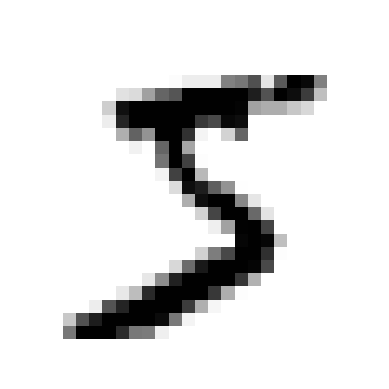

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
# The dataset is already split into a training set(first 60,000) and shuffled.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [10]:
# Classifier to only detect 5

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# Evaluation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

# Accuracy can be misleading, the dummy model only predicts False

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

# Confusion Matrices

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

# Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

# 3530 / (687 + 3530)
# 687 is the false positives, 3530 is the true positives
# measures accuracy. Most important in spam email filters. It is better to only detect true spam emails, even if 
# some spam emails get through
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [19]:
# 3530 / (1891 + 3530)
# 1891 is the false negatives, 3530 is the true positives
# measures how well the classifier can identify all positive instances. Most important in medical diagnosis, even if 
# more negative cases are identified as positive.
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
sgd_clf.decision_function([some_digit])


array([2164.22030239])

In [23]:
# get raw descision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

# get precision and recall scores for all scores
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

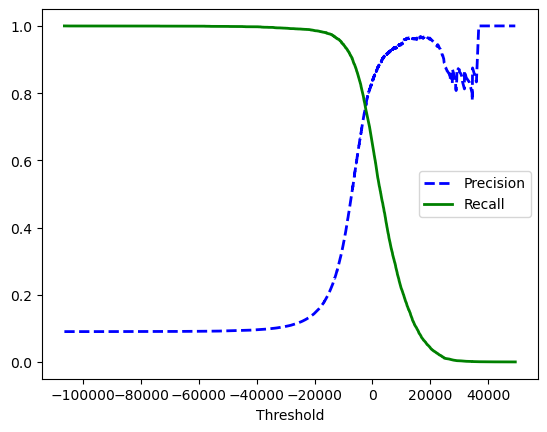

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()


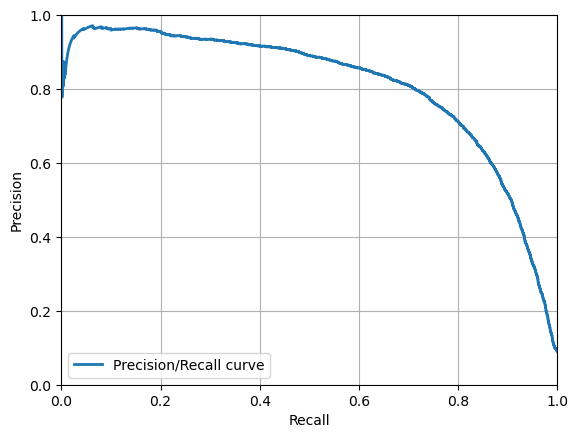

In [31]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

In [46]:
# find the lowest threshold (higher recall) for 90% precision
index_90_precision = (precisions >= 0.9).argmax()
threshold_90_precision = thresholds[index_90_precision]
threshold_90_precision

3370.0194991439557

In [49]:
# test the threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [50]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [52]:
recall_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_90_precision

0.4799852425751706